# Test File

In [1]:
import datetime as dt
import time
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np
import pandas as pd
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20.0, 8.0] # Default: [6.0, 4.0]

In [2]:
import xml.etree.ElementTree as ET
import zipfile
import csv
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

## Custom parse method so we can keep track of all the namespaces

In [3]:
NS_MAP = "xmlns:map"

# Method for parsing and keeping namespaces
def parse_nsmap(file):

    events = "start", "start-ns", "end-ns"

    root = None
    ns_map = []

    for event, elem in ET.iterparse(file, events):
        if event == "start-ns":
            ns_map.append(elem)
        elif event == "end-ns":
            ns_map.pop()
        elif event == "start":
            if root is None:
                root = elem
            elem.set(NS_MAP, dict(ns_map))

    return ET.ElementTree(root)

## Custom methods to get the full tag/attribute name using the namespaces

In [4]:
def getNS(elem, ns):
    return elem.get(NS_MAP).get(ns)

def getAttribNS(elem, ns, attr):
    return '{%s}%s' % (getNS(elem, ns), attr)

def attribWithNS(elem, ns, attr):
    return elem.attrib.get(getAttribNS(elem, ns, attr))

def tagWithNS(elem, ns, tag):
    return '{%s}%s' % (getNS(elem, ns), tag)

In [18]:
def readXML(xmlFile, path):
    splitPath = path.split('/')
    fileName = splitPath[-1][:-3]
    userName = splitPath[-2]
    tree = parse_nsmap(xmlFile)
    root = tree.getroot()
    exerciseProposals = tree.find(tagWithNS(root, 'exercise', 'ExerciseProposals'))
    print(exerciseProposals.tag)
    for proposalParts in exerciseProposals:
        print('Exercise part:', proposalParts.attrib.get('exercisePart'))
        for taskProposals in proposalParts:
            print('Task type:', attribWithNS(taskProposals, 'xsi', 'type'))
            if 'junit:JunitTestProposal' in attribWithNS(taskProposals, 'xsi', 'type'):
                completion = taskProposals.attrib.get('completion')
                print('Test completion: ', completion)
            for attempts in taskProposals:
                print('Attempt type:', attribWithNS(attempts, 'xsi', 'type'))
                timestamp = int(attempts.attrib.get('timestamp'))
                attemptDateTime = dt.datetime.fromtimestamp(int(timestamp / 1e3))  # Divide by 1000 to get from ms to seconds
                print('Attempt date time:', attemptDateTime)
                if 'jdt:JdtSourceEditEvent' in attribWithNS(attempts, 'xsi', 'type'):  # Only for source code edits
                    print('Size measure:', attempts.attrib.get('sizeMeasure'))
                    # We assume that only JdtSourceEditEvent has an edit child
                    edit = attempts.find('edit')
                    print(attribWithNS(edit, 'xsi', 'type'))
            print('--------------')
        print()

In [19]:
def getCompletionSize(xmlFile, path):
    splitPath = path.split('/')
    fileName = splitPath[-1][:-3]
    if 'Partner' not in fileName:
        return None
    userName = splitPath[-2]
    print('#USERNAME:', userName)
    tree = parse_nsmap(xmlFile)
    root = tree.getroot()
    exerciseProposals = tree.find(tagWithNS(root, 'exercise', 'ExerciseProposals'))
    if exerciseProposals is None:
        return None
    print(exerciseProposals.tag)
    completion = None
    sizeMeasure = 0
    for proposalParts in exerciseProposals:
        print('Exercise part:', proposalParts.attrib.get('exercisePart'))
        for taskProposals in proposalParts:
            print('Task type:', attribWithNS(taskProposals, 'xsi', 'type'))
            if 'junit:JunitTestProposal' in attribWithNS(taskProposals, 'xsi', 'type'):
                junitTestEvent = taskProposals.find('attempts')
                if junitTestEvent is None:  # Empty task proposal, no attempts. Thus, no completion
                    return None
                completion = float(taskProposals.attrib.get('completion'))
                print(completion)
                if completion < 1.0:
                    return None
                print('Test completion:', completion)
            for attempts in taskProposals:
                print('Attempt type:', attribWithNS(attempts, 'xsi', 'type'))
                timestamp = int(attempts.attrib.get('timestamp'))
                attemptDateTime = dt.datetime.fromtimestamp(int(timestamp / 1e3))  # Divide by 1000 to get from ms to seconds
                print('Attempt date time:', attemptDateTime)
                if getAttribNS(attempts, 'xsi', 'type') not in attempts.attrib:
                    continue
                if 'jdt:JdtSourceEditEvent' in attribWithNS(attempts, 'xsi', 'type'):  # Only for source code edits
                    sizeMeasure = attempts.attrib.get('sizeMeasure')
                    print('Size measure:', sizeMeasure)
                    # We assume that only JdtSourceEditEvent has an edit child
                    edit = attempts.find('edit')
                    if edit is not None:
                        print(attribWithNS(edit, 'xsi', 'type'))
            print('--------------')
        print()
    sizeMeasure = int(sizeMeasure)
    if sizeMeasure <= 0:
        if completion == 1.0:
            # These have probably edited the source code outside of Eclipse and just imported the files
            # Before running the Junit tests in Eclipse
            print('WHAT?')
        return None
    return (userName, sizeMeasure)

In [41]:
tag_dictionary = {
    'junit:JunitTestProposal': {
        'junit:JunitTestEvent': {
            'successCount': '',
            'failureCount': '',
            'errorCount': ''
        }
    }
}
data_dict_constants = OrderedDict({
    'SourceEdit': None, 
    'SizeMeasure': None,
    'WarningCount': None,
    'JunitTest': None,
    'Completion': None,  # Completion = successCount / totalTests
    'SuccessCount': None,
    'FailureCount': None,  # failureCount + errorCount = totalTests - successCount
    'ErrorCount': None,  # Can also occur with JdtSourceEditEvent!
    'Launch': None
    #'Mode': None  # JdtLaunchEvent mode can be both "run" and "debug"
})
junit_data = {
    'EVENT': 'JunitTest',
    'ATTRIBUTES': {
        'successCount': {
            'COLUMN_NAME': 'SuccessCount',
            'CONVERT': int
        },
        'failureCount': {
            'COLUMN_NAME': 'FailureCount',
            'CONVERT': int
        },
        'errorCount': {
            'COLUMN_NAME': 'ErrorCount',
            'CONVERT': int
        },
        'completion': {
            'COLUMN_NAME': 'Completion',
            'CONVERT': float
        }
    }
}
edit_data = {
    'sizeMeasure': 'SizeMeasure',
    'warningCount': 'WarningCount'
}

for attribute, attribute_spec in junit_data['ATTRIBUTES'].items():
    print(type(attribute_spec['CONVERT']('10')))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'float'>


In [49]:
def readXMLTS(xmlFile):
    data_list = []
    tree = parse_nsmap(xmlFile)
    root = tree.getroot()
    exerciseProposals = tree.find(tagWithNS(root, 'exercise', 'ExerciseProposals'))
    if exerciseProposals is None:
        return None
    print(exerciseProposals.tag)
    source_edit_id = 0
    junit_test_id = 0
    for proposalParts in exerciseProposals:
        print('Exercise part:', proposalParts.attrib.get('exercisePart'))
        for taskProposals in proposalParts:
            print('Task type:', attribWithNS(taskProposals, 'xsi', 'type'))
            if 'junit:JunitTestProposal' in attribWithNS(taskProposals, 'xsi', 'type'):
                #completion = taskProposals.attrib.get('completion')
                #print('Test completion: ', completion)
                junit_test_id += 1
            if 'jdt:JdtSourceEditProposal' in attribWithNS(taskProposals, 'xsi', 'type'):
                # Proposal for solving a part of a programming task.
                source_edit_id += 1
            for attempts in taskProposals:
                print('Attempt type:', attribWithNS(attempts, 'xsi', 'type'))
                timestamp = int(attempts.attrib.get('timestamp'))
                attemptDateTime = dt.datetime.fromtimestamp(int(timestamp / 1e3))  # Divide by 1000 to get from ms to seconds
                data_dict = OrderedDict({'SourceEdit': None, 
                                                   'SizeMeasure' + str(source_edit_id): None,
                                                   'WarningCount': None,
                                                   'JunitTest' + str(junit_test_id): None,
                                                   'Completion': None,  # Completion = successCount / totalTests
                                                   'SuccessCount': None,
                                                   'FailureCount': None,  # failureCount + errorCount = totalTests - successCount
                                                   'ErrorCount': None,  # Can also occur with JdtSourceEditEvent!
                                                   'Launch': None
                                                   #'Mode': None  # JdtLaunchEvent mode can be both "run" and "debug"
                                                  })
                print('Attempt date time:', attemptDateTime)
                if getAttribNS(attempts, 'xsi', 'type') not in attempts.attrib:  # Some kind of error in the xml file?
                    continue
                if 'jdt:JdtSourceEditEvent' in attribWithNS(attempts, 'xsi', 'type'):  # Only for source code edits
                    print('Size measure:', attempts.attrib.get('sizeMeasure'))
                    data_dict['SourceEdit'] = 1
                    for attribute, column_name in edit_data.items():
                        if attribute in attempts.attrib:  # TODO: If attribute never occurs; no column for it!
                            data_dict[column_name + str(source_edit_id)] = int(attempts.attrib.get(attribute))
                    # We assume that only JdtSourceEditEvent has an edit child
                    #edit = attempts.find('edit')
                    #print(attribWithNS(edit, 'xsi', 'type'))
                elif 'junit:JunitTestEvent' in attribWithNS(attempts, 'xsi', 'type'):  # Only for Junit tests
                    data_dict[junit_data['EVENT'] + str(junit_test_id)] = 1
                    #data_dict['JunitTest' + str(junit_test_id)] = 1
                    #data_dict['Completion'] = float(attempts.attrib.get('completion'))
                    for attribute, attribute_spec in junit_data['ATTRIBUTES'].items():
                        column_name = attribute_spec['COLUMN_NAME']
                        convert_method = attribute_spec['CONVERT']
                        if attribute in attempts.attrib:
                            data_dict[column_name + str(junit_test_id)] = convert_method(attempts.attrib.get(attribute))
                elif 'jdt:JdtLaunchEvent' in attribWithNS(attempts, 'xsi', 'type'):  # Only for Launch events
                    data_dict['Launch'] = 1
                    #data_dict['Mode'] = attempts.attrib.get('mode')
                data_list.append([attemptDateTime, data_dict])
            print('--------------')
        print()
    data_list.sort(key=lambda x: x[0])  # Sorting by timestamp (attemptDateTime)
    df_index = pd.DatetimeIndex([x[0] for x in data_list])
    df = pd.DataFrame([x[1] for x in data_list], index=df_index)
    return df

In [50]:
#p = '../data/+ÿving 5/0245601978/Partner.ex'
p = '../data/+ÿving 5/0141126194/Card.ex'
df = None
with open(p, 'r') as xml_file:
    split_path = p.split('/')
    file_name = split_path[-1][:-3]
    user_name = split_path[-2]
    df = readXMLTS(xml_file)

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 22:56:38
Size measure: 32
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 22:56:38
Size measure: 73
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 22:59:29
Size measure: 77
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:13:12
Size measure: 80
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:16:13
Size measure: 80
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:16:44
Size measure: 80
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:18:20
Size measure: 80
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:18:38
Size measure: 80
Attempt type: jdt:JdtSourceEditEvent
Attempt date ti

In [63]:
df.update(df.filter(regex='^SizeMeasure\d{1,}$').ffill())  # Forward-filling all columns beginning with 'SizeMeasure'
df['TotalSizeMeasure'] = df.filter(regex='^SizeMeasure\d{1,}$').sum(axis=1)
df.WarningCount.ffill(inplace=True)  # 
df.Completion.ffill(inplace=True)
df.SuccessCount.ffill(inplace=True)
df.FailureCount.ffill(inplace=True)
df.ErrorCount.ffill(inplace=True)
#df['SizeMeasure'].bfill(inplace=True)
#df['Completion'].ffill(inplace=True)
#df['Completion'].bfill(inplace=True)

In [53]:
df

SourceEdit  SizeMeasure1 WarningCount  JunitTest0  \
2017-02-23 22:56:38         1.0          32.0         None         NaN   
2017-02-23 22:56:38         1.0           NaN         None         NaN   
2017-02-23 22:57:24         NaN           NaN         None         NaN   
2017-02-23 22:59:26         1.0           NaN         None         NaN   
2017-02-23 22:59:29         1.0           NaN         None         NaN   
2017-02-23 23:00:53         1.0           NaN         None         NaN   
2017-02-23 23:02:30         1.0           NaN         None         NaN   
2017-02-23 23:03:17         1.0           NaN         None         NaN   
2017-02-23 23:13:12         1.0           NaN         None         NaN   
2017-02-23 23:13:40         NaN           NaN         None         NaN   
2017-02-23 23:13:51         NaN           NaN         None         NaN   
2017-02-23 23:14:37         1.0           NaN         None         NaN   
2017-02-23 23:15:51         1.0           NaN         None         NaN   
2017-02-23 23:15:53         NaN           NaN         None         NaN   
2017-02-23 23:15:56         NaN           NaN         None         NaN   
2017-02-23 23:16:13         1.0           NaN         None         NaN   
2017-02-23 23:16:13         NaN           NaN         None         NaN   
2017-02-23 23:16:22         NaN           NaN         None         NaN   
2017-02-23 23:16:36         NaN           NaN         None         NaN   
2017-02-23 23:16:44         1.0           NaN         None         NaN   
2017-02-23 23:16:45         NaN           NaN         None         NaN   
2017-02-23 23:17:01         NaN           NaN         None         NaN   
2017-02-23 23:17:06         NaN           NaN         None         NaN   
2017-02-23 23:18:20         1.0           NaN         None         NaN   
2017-02-23 23:18:20         NaN           NaN         None         NaN   
2017-02-23 23:18:23         NaN           NaN         None         NaN   
2017-02-23 23:18:27         NaN           NaN         None         NaN   
2017-02-23 23:18:38         1.0           NaN         None         NaN   
2017-02-23 23:18:39         NaN           NaN         None         NaN   
2017-02-23 23:31:01         1.0           NaN         None         NaN   
2017-02-23 23:31:05         NaN           NaN         None         NaN   
2017-02-23 23:31:15         NaN           NaN         None         NaN   
2017-02-23 23:34:25         1.0           NaN         None         NaN   
2017-02-23 23:34:27         NaN           NaN         None         NaN   
2017-02-23 23:34:29         NaN           NaN         None         NaN   
2017-02-23 23:34:33         NaN           NaN         None         NaN   
2017-02-23 23:34:49         NaN           NaN         None         NaN   
2017-02-24 08:31:29         NaN           NaN         None         NaN   
2017-02-24 08:46:42         1.0           NaN         None         NaN   
2017-02-24 08:46:43         NaN           NaN         None         NaN   
2017-02-24 08:46:59         1.0           NaN         None         NaN   
2017-02-24 08:47:29         1.0           NaN         None         NaN   
2017-02-24 08:47:34         1.0           NaN         None         NaN   

                    Completion SuccessCount FailureCount ErrorCount  Launch  \
2017-02-23 22:56:38       None         None         None       None     NaN   
2017-02-23 22:56:38       None         None         None       None     NaN   
2017-02-23 22:57:24       None         None         None       None     NaN   
2017-02-23 22:59:26       None         None         None       None     NaN   
2017-02-23 22:59:29       None         None         None       None     NaN   
2017-02-23 23:00:53       None         None         None       None     NaN   
2017-02-23 23:02:30       None         None         None       None     NaN   
2017-02-23 23:03:17       None         None         None       None     NaN   
2017-02-23 23:13:12       None         None         N

In [90]:
grades = OrderedDict()
with open('../brukernummer-karakter.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile, fieldnames=['hash', 'grade'])
    for row in reader:
        grades[row['hash']] = row['grade']

In [91]:
grades

OrderedDict([('1961606504', 'D'),
             ('0003195112', 'A'),
             ('2370221083', 'A'),
             ('3417169296', 'C'),
             ('3049944332', 'F'),
             ('3169265502', 'B'),
             ('1309367009', 'A'),
             ('2900473238', 'F'),
             ('0100313338', 'F'),
             ('3528648608', 'F'),
             ('3635712884', 'F'),
             ('3172735784', 'A'),
             ('3092715252', 'C'),
             ('2885425503', 'F'),
             ('0053596332', 'A'),
             ('3401034429', 'C'),
             ('3311094284', 'B'),
             ('1395134805', 'E'),
             ('0244999521', 'C'),
             ('4025554098', 'F'),
             ('1625178573', 'F'),
             ('3447007398', 'F'),
             ('2747401993', 'A'),
             ('2877527733', 'C'),
             ('1843717383', 'F'),
             ('0109441257', 'F'),
             ('3810295105', 'C'),
             ('3565377643', 'C'),
             ('0312660958', 'C'),
             (

In [32]:
def get_features(df, hash_id):
    if 'SizeMeasure' not in df.columns:
        return None
    df.update(df.filter(regex='^SizeMeasure\d{1,}$').ffill())  # Forward-filling
    df.WarningCount.ffill(inplace=True)  # 
    df.Completion.ffill(inplace=True)
    df.SuccessCount.ffill(inplace=True)
    df.FailureCount.ffill(inplace=True)
    df.ErrorCount.ffill(inplace=True)
    f_df = pd.DataFrame(index=[hash_id])
    f_df['MaxSizeMeasure'] = df.SizeMeasure.max()
    f_df['FinalSizeMeasure'] = df.iloc[-1].SizeMeasure  # Works because SizeMeasure is forward-filled!
    f_df['JunitRuns'] = df.JunitTest.count()
    if f_df.JunitRuns.any() == 0:
        return None
    #if df.Completion.last_valid_index() is None:
        #return None
    #f_df['FinalCompletion'] = df.loc[df.Completion.last_valid_index()].Completion
    f_df['SizeMeasure_div_JunitRuns'] = (f_df.FinalSizeMeasure / f_df.JunitRuns)[-1]
    f_df['Avg_SizeMeasure_div_Completion'] = (df.SizeMeasure * df.Completion).mean()
    f_df['MinutesSpent'] = ((df.index[-1].value - df.index[0].value) // 10**9) / 60
    if hash_id not in grades:
        return None
    f_df['Grade'] = grades[hash_id]
    return f_df

In [31]:
get_features(df, "0245601978")

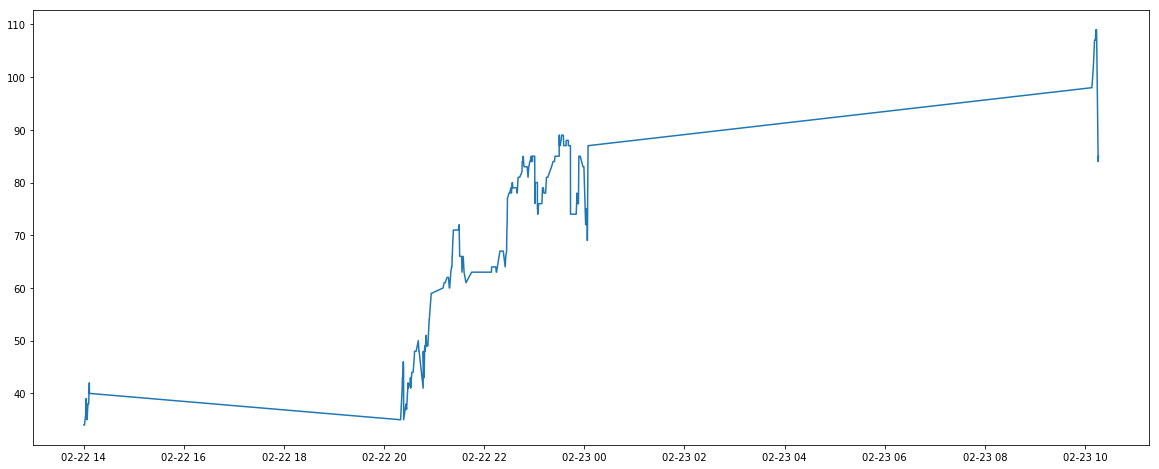

In [96]:
plt.plot(df.loc[:].SizeMeasure)

In [12]:
df.plot()

AttributeError: 'NoneType' object has no attribute 'plot'

In [13]:
snippet = df#.loc['2017-02-23 00:00:00':'2017-02-23 10:30:00']
snippet.SizeMeasure.plot(label="SizeMeasure", legend=True)
snippet.SourceEdit.plot(secondary_y=True, label="SourceEdit", legend=True)

AttributeError: 'NoneType' object has no attribute 'SizeMeasure'

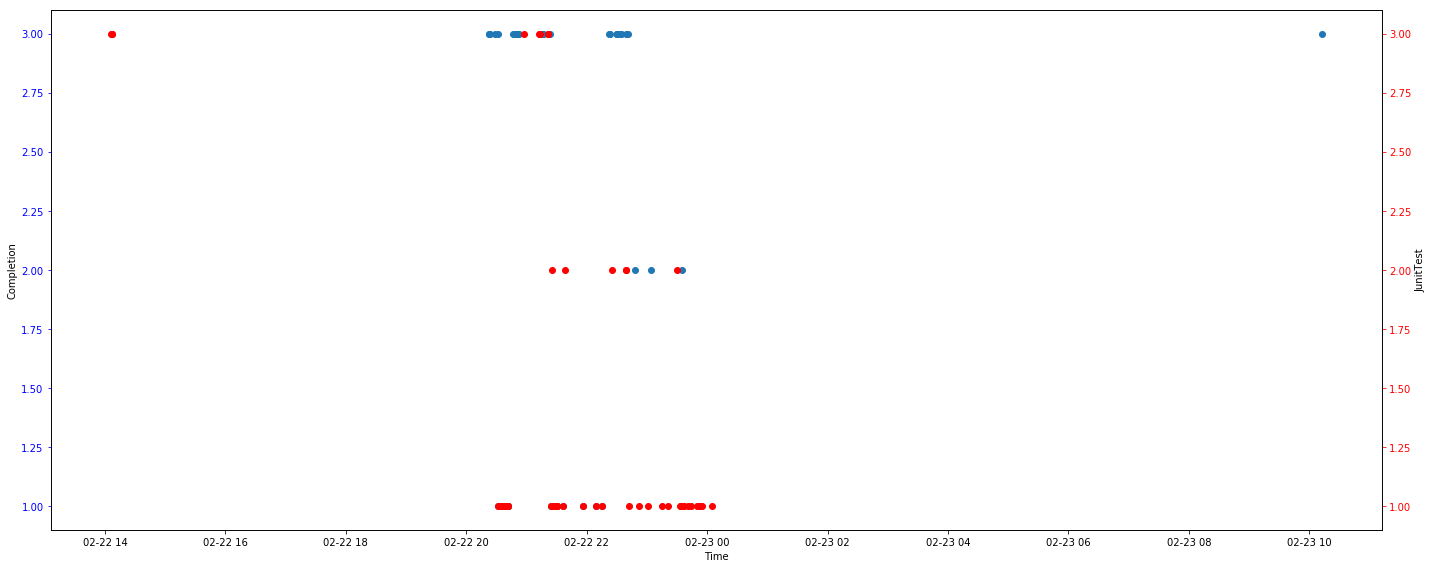

In [65]:
fig, ax1 = plt.subplots()
ax1.plot(df.ErrorCount, marker='o', linestyle="None")
ax1.set_xlabel('Time')
ax1.set_ylabel('Completion')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(df.FailureCount, marker='o', linestyle="None", color='r')
ax2.set_ylabel('JunitTest')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [10]:


def readXMLFileFromZip(path):
    df_partner = pd.DataFrame()
    with zipfile.ZipFile(path, 'r') as myzip:
        exFileList = myzip.namelist()
        for exFilePath in exFileList:
            with myzip.open(exFilePath, 'r') as xmlFile:
                split_path = exFilePath.split('/')
                file_name = split_path[-1][:-3]
                user_name = split_path[-2]
                df = readXMLTS(xmlFile)
                if df is None:
                    continue
                feature_df = get_features(df, user_name)
                if feature_df is not None:
                    df_partner = df_partner.append(feature_df)
    return df_partner

In [26]:
df_partner = readXMLFileFromZip('../data/oving5-anon.zip')

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 15:38:39
Size measure: 36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 15:41:46
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 15:43:13
Size measure: 40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 15:43:27
Size measure: 42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 15:43:42
Size measure: 42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 15:44:19
Size measure: 42
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 15:43:27
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 15:43:43
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 15:44:21
--------------
Task type: 

Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:19:53
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:20:11
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:20:38
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:20:52
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:21:32
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:21:54
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:23:59
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:24:52
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:25:24
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:25:32
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:27:32
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:27:40
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:27:47
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 1

Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:11:32
Size measure: 42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:11:49
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:12:18
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:12:44
Size measure: 38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:13:00
Size measure: 38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:13:46
Size measure: 38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:14:51
Size measure: 38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:15:15
Size measure: 38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:20:45
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:23:00
Size measure: 53
Attempt type: jdt:JdtSourceEditEvent
Attempt date tim

Attempt date time: 2017-02-23 11:48:30
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 11:52:37
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 11:55:11
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 15:52:41
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 15:56:14
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 16:02:58
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 10:50:59
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 11:01:04
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 11:26:46
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 11:32:40
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 11:34:21
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 11:43:42
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 15:49:13
Attempt type: junit:JunitTestEven

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 11:50:07
Size measure: 41
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:22:42
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:29:02
Size measure: 66
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:33:54
Size measure: 72
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:36:13
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:38:02
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:40:25
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:42:00
Size measure: 72
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:42:33
Size measure: 73
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:42:40
Size measure: 73
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:

Attempt type: None
Attempt date time: 2017-02-20 12:22:42
Attempt type: None
Attempt date time: 2017-02-20 12:22:44
Attempt type: None
Attempt date time: 2017-02-20 12:22:44
Attempt type: None
Attempt date time: 2017-02-20 12:22:45
Attempt type: None
Attempt date time: 2017-02-20 12:22:46
Attempt type: None
Attempt date time: 2017-02-20 12:22:46
Attempt type: None
Attempt date time: 2017-02-20 12:22:47
Attempt type: None
Attempt date time: 2017-02-20 12:22:47
Attempt type: None
Attempt date time: 2017-02-20 12:22:48
Attempt type: None
Attempt date time: 2017-02-20 12:22:49
Attempt type: None
Attempt date time: 2017-02-20 12:22:50
Attempt type: None
Attempt date time: 2017-02-20 12:22:52
Attempt type: None
Attempt date time: 2017-02-20 12:23:06
Attempt type: None
Attempt date time: 2017-02-20 12:23:15
Attempt type: None
Attempt date time: 2017-02-20 12:23:18
Attempt type: None
Attempt date time: 2017-02-20 12:26:42
Attempt type: None
Attempt date time: 2017-02-20 12:26:49
Attempt type: 

--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:PartTaskProposal
--------------

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 11:32:28
Size measure: 44
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 10:49:07
Size measure: 88
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 11:01:28
Size measure: 86
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 11:32:28
Size measure: 81
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 11:32:44
Size measure: 79
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 11:34:02
Size measure: 78
Attempt type: jdt:JdtSourceEditEvent
Attempt da

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:54:24
Size measure: 49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:54:40
Size measure: 49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:54:51
Size measure: 49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 13:08:20
Size measure: 51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 13:08:51
Size measure: 51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 13:09:07
Size measure: 51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 13:11:23
Size measure: 53
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 13:14:47
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 13:18:27
Size measure: 65
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 13:20:38
Size measure: 69
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 13:

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:46:26
Size measure: 51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:46:28
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:51:36
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:52:26
Size measure: 53
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:52:59
Size measure: 53
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:53:04
Size measure: 55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:55:18
Size measure: 56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:55:33
Size measure: 58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:55:35
Size measure: 58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:55:59
Size measure: 53
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:

Attempt date time: 2017-02-18 23:24:39
Size measure: 33
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 09:00:22
Size measure: 51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 09:07:36
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 09:08:05
Size measure: 51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 09:11:15
Size measure: 51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 09:12:31
Size measure: 51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 09:13:26
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 09:14:09
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 09:16:25
Size measure: 54
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 22:11:13
Size measure: 5
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:36:19
Size measure: 87
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:37:12
Size measure: 87
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:37:43
Size measure: 87
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:38:14
Size measure: 88
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:40:52
Size measure: 87
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:41:08
Size measure: 87
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:43:23
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:47:29
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:50:06
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:50:10
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 23:

Attempt date time: 2017-02-27 20:15:19
Size measure: 76
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:17:22
Size measure: 76
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:27:00
Size measure: 75
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:29:33
Size measure: 77
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:31:00
Size measure: 77
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:33:51
Size measure: 78
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:34:17
Size measure: 78
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:36:07
Size measure: 81
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:38:57
Size measure: 81
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:39:22
Size measure: 79
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:39:46
Size measure: 81
Attempt type: 

Attempt date time: 2017-02-18 18:16:46
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:PartTaskProposal
--------------

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-15 12:35:28
Size measure: 5
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-15 12:36:43
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-15 13:22:15
Size measure: 49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-15 13:33:13
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-15 13:34:03
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-15 13:4

Attempt date time: 2017-02-28 21:43:57
Size measure: 19
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:44:01
Size measure: 19
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:49:32
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:50:46
Size measure: 51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:05:46
Size measure: 91
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:07:36
Size measure: 99
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:07:38
Size measure: 99
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:09:51
Size measure: 98
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:12:08
Size measure: 97
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:18:28
Size measure: 100
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:18:34
Size measure: 100
Attempt type

Size measure: 190
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:39:10
Size measure: 190
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:39:34
Size measure: 190
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:40:01
Size measure: 190
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:40:08
Size measure: 190
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:40:55
Size measure: 190
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:41:22
Size measure: 190
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:41:56
Size measure: 191
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 22:31:21
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 22:32:11
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 22:32:42
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-

Attempt date time: 2017-02-27 12:42:15
Size measure: 34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:42:24
Size measure: 35
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:43:42
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:44:04
Size measure: 39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:45:05
Size measure: 39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:45:47
Size measure: 39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:45:48
Size measure: 39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:45:50
Size measure: 39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:47:52
Size measure: 41
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:48:17
Size measure: 41
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:48:27
Size measure: 42
Attempt type: 

Attempt date time: 2017-02-23 15:49:51
Size measure: 52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 15:50:14
Size measure: 52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 15:50:51
Size measure: 53
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 15:50:59
Size measure: 53
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 15:51:22
Size measure: 55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 15:51:41
Size measure: 55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 15:51:46
Size measure: 55
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:34:59
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:36:23
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:36:49
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 15:37:13
Attempt type: jdt:JdtLaunchEvent
Attempt date time

Size measure: 57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 20:06:13
Size measure: 58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 20:07:33
Size measure: 58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 20:07:36
Size measure: 58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 20:07:56
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 20:07:58
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 20:08:03
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 20:08:47
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 20:09:09
Size measure: 65
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 20:09:21
Size measure: 65
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 20:09:35
Size measure: 66
Attempt type: jdt:JdtSourceEditEvent
Attempt date tim

Size measure: 31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 10:06:17
Size measure: 31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 10:08:10
Size measure: 36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 10:10:22
Size measure: 38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 10:12:52
Size measure: 42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 10:14:50
Size measure: 47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 10:19:07
Size measure: 51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 10:21:39
Size measure: 55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 10:23:11
Size measure: 55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 10:31:49
Size measure: 55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 10:32:00
Size measure: 55
Attempt type: jdt:JdtSourceEditEvent
Attempt date tim

Size measure: 34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:41:11
Size measure: 33
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:41:25
Size measure: 29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:42:07
Size measure: 29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:42:12
Size measure: 29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:42:27
Size measure: 29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:43:06
Size measure: 29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:43:29
Size measure: 29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:43:40
Size measure: 29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:44:22
Size measure: 28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:44:24
Size measure: 28
Attempt type: jdt:JdtSourceEditEvent
Attempt date tim

Attempt date time: 2017-02-23 22:38:57
Size measure: 229
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 01:22:43
Size measure: 250
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 01:22:48
Size measure: 249
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 01:24:07
Size measure: 251
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 01:26:53
Size measure: 247
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 01:27:28
Size measure: 247
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 01:30:44
Size measure: 255
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 01:31:23
Size measure: 255
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 01:33:47
Size measure: 259
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 01:39:59
Size measure: 259
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 01:43:32
Size measure: 246
Att

Attempt date time: 2017-02-22 14:38:34
Size measure: 30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 14:39:34
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 14:40:54
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 14:44:50
Size measure: 36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 14:45:30
Size measure: 36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 14:46:29
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 14:47:20
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 14:51:33
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 21:14:49
Size measure: 33
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 21:17:04
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 21:17:27
Size measure: 37
Attempt type: 

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:01:41
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:03:08
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:04:16
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:07:38
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:11:56
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:12:04
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:14:38
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:19:23
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:20:59
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:37:45
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:39:20
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:41:03
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-18 10:50:21
Attempt type: junit:JunitTestEvent
Att

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:51:43
Size measure: 109
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:52:24
Size measure: 109
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:52:32
Size measure: 109
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:52:40
Size measure: 109
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:52:58
Size measure: 110
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:53:19
Size measure: 110
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:54:09
Size measure: 110
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:54:53
Size measure: 110
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:54:56
Size measure: 110
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:55:44
Size measure: 110
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017

Attempt date time: 2017-02-26 13:37:55
Attempt type: None
Attempt date time: 2017-02-26 13:37:56
Attempt type: None
Attempt date time: 2017-02-26 13:47:27
Attempt type: None
Attempt date time: 2017-02-26 13:48:31
Attempt type: None
Attempt date time: 2017-02-26 13:48:33
Attempt type: None
Attempt date time: 2017-02-26 13:48:34
Attempt type: None
Attempt date time: 2017-02-26 13:48:35
Attempt type: None
Attempt date time: 2017-02-26 13:48:36
Attempt type: None
Attempt date time: 2017-02-26 13:48:37
Attempt type: None
Attempt date time: 2017-02-26 13:48:39
Attempt type: None
Attempt date time: 2017-02-26 13:48:41
Attempt type: None
Attempt date time: 2017-02-26 13:48:42
Attempt type: None
Attempt date time: 2017-02-26 13:48:43
Attempt type: None
Attempt date time: 2017-02-26 13:48:44
Attempt type: None
Attempt date time: 2017-02-26 13:48:44
Attempt type: None
Attempt date time: 2017-02-26 13:48:46
Attempt type: None
Attempt date time: 2017-02-26 13:48:47
--------------
Task type: workben

Size measure: 112
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 18:37:53
Size measure: 113
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 18:39:58
Size measure: 113
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 18:40:23
Size measure: 114
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 18:40:51
Size measure: 111
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 18:48:28
Size measure: 125
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 18:51:57
Size measure: 122
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 18:52:22
Size measure: 122
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 18:58:20
Size measure: 129
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:00:06
Size measure: 136
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:01:17
Size measure: 136
Attempt type: jdt:JdtSourceEditEvent
Attem

--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:PartTaskProposal
--------------

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 14:55:26
Size measure: 5
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 14:55:41
Size measure: 41
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 14:55:55
Size measure: 5
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 14:56:25
Size measure: 70
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 14:57:40
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-18 14:57:58
Size measure: 76
Attempt type: jdt:JdtSourceEditEvent
Attempt date

Attempt type: None
Attempt date time: 2017-02-27 15:59:51
Attempt type: None
Attempt date time: 2017-02-27 15:59:52
Attempt type: None
Attempt date time: 2017-02-27 15:59:52
Attempt type: None
Attempt date time: 2017-02-27 16:00:19
--------------
Task type: workbench:CommandExecutionProposal
Attempt type: None
Attempt date time: 2017-02-27 15:27:38
Attempt type: None
Attempt date time: 2017-02-27 15:28:00
Attempt type: None
Attempt date time: 2017-02-27 15:29:38
Attempt type: None
Attempt date time: 2017-02-27 15:29:46
Attempt type: None
Attempt date time: 2017-02-27 15:29:49
Attempt type: None
Attempt date time: 2017-02-27 15:29:50
Attempt type: None
Attempt date time: 2017-02-27 15:29:53
Attempt type: None
Attempt date time: 2017-02-27 15:30:03
Attempt type: None
Attempt date time: 2017-02-27 15:30:10
Attempt type: None
Attempt date time: 2017-02-27 15:30:27
Attempt type: None
Attempt date time: 2017-02-27 15:30:28
Attempt type: None
Attempt date time: 2017-02-27 15:33:50
Attempt typ

Attempt type: None
Attempt date time: 2017-02-27 22:14:50
Attempt type: None
Attempt date time: 2017-02-27 22:14:50
Attempt type: None
Attempt date time: 2017-02-27 22:15:12
Attempt type: None
Attempt date time: 2017-02-27 22:15:20
Attempt type: None
Attempt date time: 2017-02-27 22:15:23
Attempt type: None
Attempt date time: 2017-02-27 22:16:04
Attempt type: None
Attempt date time: 2017-02-27 22:16:21
Attempt type: None
Attempt date time: 2017-02-27 22:17:34
Attempt type: None
Attempt date time: 2017-02-27 22:20:10
Attempt type: None
Attempt date time: 2017-02-27 22:20:49
Attempt type: None
Attempt date time: 2017-02-27 22:21:03
Attempt type: None
Attempt date time: 2017-02-27 22:21:03
Attempt type: None
Attempt date time: 2017-02-27 22:21:04
Attempt type: None
Attempt date time: 2017-02-27 22:21:17
Attempt type: None
Attempt date time: 2017-02-27 22:21:19
Attempt type: None
Attempt date time: 2017-02-27 22:21:32
Attempt type: None
Attempt date time: 2017-02-27 22:21:33
Attempt type: 

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 17:35:04
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 17:36:48
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 17:37:44
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 17:38:22
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:07:42
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:08:27
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:08:58
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 18:12:14
Size measure: 45
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 17:32:43
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 17:37:18
Attempt ty

Size measure: 92
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:36:59
Size measure: 91
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:37:33
Size measure: 92
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:38:32
Size measure: 93
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:39:47
Size measure: 93
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:40:26
Size measure: 93
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:40:56
Size measure: 93
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:41:15
Size measure: 93
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:41:25
Size measure: 93
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:41:35
Size measure: 93
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 19:45:52
Size measure: 93
Attempt type: jdt:JdtSourceEditEvent
Attempt date tim

Attempt type: None
Attempt date time: 2017-02-25 11:39:49
Attempt type: None
Attempt date time: 2017-02-25 11:39:53
Attempt type: None
Attempt date time: 2017-02-25 11:42:08
Attempt type: None
Attempt date time: 2017-02-25 11:44:18
Attempt type: None
Attempt date time: 2017-02-25 11:44:30
Attempt type: None
Attempt date time: 2017-02-25 11:44:38
Attempt type: None
Attempt date time: 2017-02-25 11:44:56
Attempt type: None
Attempt date time: 2017-02-25 11:45:04
Attempt type: None
Attempt date time: 2017-02-25 11:45:12
--------------
Task type: workbench:CommandExecutionProposal
Attempt type: None
Attempt date time: 2017-02-25 10:28:52
Attempt type: None
Attempt date time: 2017-02-25 11:40:12
Attempt type: None
Attempt date time: 2017-02-25 11:41:03
Attempt type: None
Attempt date time: 2017-02-25 11:41:05
Attempt type: None
Attempt date time: 2017-02-25 11:41:22
Attempt type: None
Attempt date time: 2017-02-25 11:42:00
Attempt type: None
Attempt date time: 2017-02-25 11:42:23
Attempt typ

Size measure: 127
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 12:15:22
Size measure: 127
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 12:15:49
Size measure: 127
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 12:16:16
Size measure: 127
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 12:16:53
Size measure: 125
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 12:17:23
Size measure: 125
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 12:17:29
Size measure: 125
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 12:17:38
Size measure: 125
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 12:17:44
Size measure: 125
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 12:18:08
Size measure: 125
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 12:20:26
Size measure: 118
Attempt type: jdt:JdtSourceEditEvent
Attem

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:20:13
Size measure: 34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:20:33
Size measure: 35
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:20:57
Size measure: 35
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:21:13
Size measure: 35
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:26:31
Size measure: 35
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:28:24
Size measure: 40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:28:47
Size measure: 40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:29:37
Size measure: 40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:29:46
Size measure: 40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:29:55
Size measure: 40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 22:

Attempt date time: 2017-03-01 07:54:17
Attempt type: None
Attempt date time: 2017-03-01 07:54:19
Attempt type: None
Attempt date time: 2017-03-01 07:54:26
Attempt type: None
Attempt date time: 2017-03-01 07:54:39
Attempt type: None
Attempt date time: 2017-03-01 07:56:20
--------------
Task type: workbench:PartTaskProposal
Attempt type: None
Attempt date time: 2017-03-01 07:42:38
Attempt type: None
Attempt date time: 2017-03-01 07:42:56
Attempt type: None
Attempt date time: 2017-03-01 07:44:22
Attempt type: None
Attempt date time: 2017-03-01 07:45:58
Attempt type: None
Attempt date time: 2017-03-01 07:46:12
Attempt type: None
Attempt date time: 2017-03-01 07:55:14
Attempt type: None
Attempt date time: 2017-03-01 07:56:47
Attempt type: None
Attempt date time: 2017-03-01 08:18:58
Attempt type: None
Attempt date time: 2017-03-01 08:19:19
Attempt type: None
Attempt date time: 2017-03-01 08:20:58
Attempt type: None
Attempt date time: 2017-03-01 08:30:16
Attempt type: None
Attempt date time: 

Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 15:52:55
Size measure: 94
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 09:21:53
Size measure: 60
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 09:25:27
Size measure: 60
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 09:30:51
Size measure: 64
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 09:33:43
Size measure: 69
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 09:22:21
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 09:25:37
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 09:30:55
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 09:33:46
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventPro

Attempt date time: 2017-02-26 18:21:19
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 18:21:37
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 18:21:43
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 18:22:07
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 18:22:13
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 18:23:25
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 18:23:30
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 19:22:52
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 19:23:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 19:23:41
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 07:41:03
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 07:41:55
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 07:42:24
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 07:42:59
Attempt type: jdt:JdtLaun

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:24:01
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:30:32
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:32:59
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:39:26
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:40:57
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:41:26
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:41:50
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:43:20
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:45:07
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:47:20
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:47:37
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:50:15
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:53:24
Attempt type: junit:JunitTestEvent
Att

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 09:57:36
Size measure: 134
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 09:59:19
Size measure: 132
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 09:59:20
Size measure: 133
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 09:59:36
Size measure: 133
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 10:00:45
Size measure: 133
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 10:01:11
Size measure: 133
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 10:01:18
Size measure: 133
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 10:01:42
Size measure: 133
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 10:01:43
Size measure: 133
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 10:02:08
Size measure: 133
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 16:12:35
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 16:12:57
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 16:14:54
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 16:15:32
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-24 14:47:35
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 16:30:56
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 16:31:47
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 16:36:25
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 16:36:49
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 16:36:59
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-24 14:47:50
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
--------------
Task type: workbench:DebugEventProposa

Attempt date time: 2017-02-21 09:09:43
Attempt type: None
Attempt date time: 2017-02-21 09:09:45
Attempt type: None
Attempt date time: 2017-02-21 09:09:46
Attempt type: None
Attempt date time: 2017-02-21 09:09:47
Attempt type: None
Attempt date time: 2017-02-21 09:09:47
Attempt type: None
Attempt date time: 2017-02-21 09:09:48
Attempt type: None
Attempt date time: 2017-02-21 09:09:50
Attempt type: None
Attempt date time: 2017-02-21 09:09:51
Attempt type: None
Attempt date time: 2017-02-21 09:09:53
Attempt type: None
Attempt date time: 2017-02-21 09:09:54
Attempt type: None
Attempt date time: 2017-02-21 09:09:55
Attempt type: None
Attempt date time: 2017-02-21 09:09:56
Attempt type: None
Attempt date time: 2017-02-21 09:09:58
Attempt type: None
Attempt date time: 2017-02-21 09:10:00
Attempt type: None
Attempt date time: 2017-02-21 09:10:05
Attempt type: None
Attempt date time: 2017-02-21 09:10:07
Attempt type: None
Attempt date time: 2017-02-21 09:10:10
Attempt type: None
Attempt date t

Attempt type: None
Attempt date time: 2017-02-28 21:12:46
Attempt type: None
Attempt date time: 2017-02-28 21:12:46
Attempt type: None
Attempt date time: 2017-02-28 21:12:46
Attempt type: None
Attempt date time: 2017-02-28 21:12:46
Attempt type: None
Attempt date time: 2017-02-28 21:12:46
Attempt type: None
Attempt date time: 2017-02-28 21:12:46
Attempt type: None
Attempt date time: 2017-02-28 21:12:46
Attempt type: None
Attempt date time: 2017-02-28 21:12:47
Attempt type: None
Attempt date time: 2017-02-28 21:12:47
Attempt type: None
Attempt date time: 2017-02-28 21:12:47
Attempt type: None
Attempt date time: 2017-02-28 21:12:47
Attempt type: None
Attempt date time: 2017-02-28 21:12:47
Attempt type: None
Attempt date time: 2017-02-28 21:12:47
Attempt type: None
Attempt date time: 2017-02-28 21:12:47
Attempt type: None
Attempt date time: 2017-02-28 21:12:47
Attempt type: None
Attempt date time: 2017-02-28 21:12:47
Attempt type: None
Attempt date time: 2017-02-28 21:12:47
Attempt type: 

Size measure: 35
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 10:28:18
Size measure: 36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 10:31:59
Size measure: 38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 10:32:41
Size measure: 42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 10:33:21
Size measure: 46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 10:33:42
Size measure: 47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 10:34:18
Size measure: 47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 10:35:07
Size measure: 47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 10:59:06
Size measure: 47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 11:17:29
Size measure: 47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 11:19:53
Size measure: 47
Attempt type: jdt:JdtSourceEditEvent
Attempt date tim

Size measure: 29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:34:59
Size measure: 29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:35:15
Size measure: 30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:35:16
Size measure: 29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:35:37
Size measure: 30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:36:59
Size measure: 30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:37:46
Size measure: 30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:38:05
Size measure: 30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:38:10
Size measure: 30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:39:11
Size measure: 30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:39:30
Size measure: 30
Attempt type: jdt:JdtSourceEditEvent
Attempt date tim

Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:04:37
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:04:46
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:05:25
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:10:25
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:13:26
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:15:25
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:16:23
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:17:50
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:18:08
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:25:40
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:32:59
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:33:08
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 17:33:20
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-19 1

Size measure: 46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 22:28:00
Size measure: 49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 22:28:46
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 22:29:37
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 22:29:47
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 22:29:56
Size measure: 47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 22:30:12
Size measure: 49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 22:30:54
Size measure: 48
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 22:35:59
Size measure: 49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 22:36:12
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 22:37:57
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date tim

Attempt date time: 2017-02-19 22:58:44
Size measure: 159
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 22:58:48
Size measure: 159
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 22:59:05
Size measure: 159
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 23:02:44
Size measure: 160
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 23:02:50
Size measure: 160
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 23:03:01
Size measure: 161
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 23:03:20
Size measure: 160
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 23:03:55
Size measure: 161
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 23:04:45
Size measure: 161
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 23:05:02
Size measure: 162
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-19 23:05:25
Size measure: 163
Att

Attempt date time: 2017-02-20 10:55:23
Size measure: 79
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-20 11:04:53
Size measure: 79
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-20 14:35:51
Size measure: 83
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-20 14:45:13
Size measure: 84
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-20 14:45:29
Size measure: 85
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-20 14:45:40
Size measure: 86
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 16:47:02
Size measure: 85
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 16:47:14
Size measure: 85
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 16:48:37
Size measure: 90
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 16:49:05
Size measure: 82
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 16:49:54
Size measure: 85
Attempt type: 

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 00:23:53
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 00:28:36
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 00:29:09
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 00:31:22
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 00:31:40
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 00:39:09
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Attempt type: None
Attempt date time: 2017-02-28 23:04:11
Attempt type: None
Attempt date time: 2017-02-28 23:05:51
Attempt type: None
Attempt date time: 2017-02-28 23:07:24
Attempt type: None
Attempt date time: 2017-02-28 23:08:18
Attempt type: None
Attempt date time: 2017-02-28 23:09:47
Attempt type: None
Attempt date time: 2017-02-28 23:10:31
Attempt type: None
Attempt date time: 2017-02-28 23:10:36
Attempt type: None
Attempt date time: 2017-02-28 23:13:26
Attempt t

Attempt date time: 2017-02-28 15:31:31
Attempt type: None
Attempt date time: 2017-02-28 15:31:32
Attempt type: None
Attempt date time: 2017-02-28 15:31:33
Attempt type: None
Attempt date time: 2017-02-28 15:31:34
Attempt type: None
Attempt date time: 2017-02-28 15:44:12
Attempt type: None
Attempt date time: 2017-02-28 15:44:23
Attempt type: None
Attempt date time: 2017-02-28 15:44:23
Attempt type: None
Attempt date time: 2017-02-28 15:44:24
Attempt type: None
Attempt date time: 2017-02-28 15:44:25
Attempt type: None
Attempt date time: 2017-02-28 15:44:26
Attempt type: None
Attempt date time: 2017-02-28 15:44:26
Attempt type: None
Attempt date time: 2017-02-28 15:44:27
Attempt type: None
Attempt date time: 2017-02-28 15:44:27
Attempt type: None
Attempt date time: 2017-02-28 15:44:28
Attempt type: None
Attempt date time: 2017-02-28 15:44:29
Attempt type: None
Attempt date time: 2017-02-28 15:44:29
Attempt type: None
Attempt date time: 2017-02-28 15:44:30
Attempt type: None
Attempt date t

Size measure: 113
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 01:20:30
Size measure: 116
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 01:22:09
Size measure: 116
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 01:25:06
Size measure: 122
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 01:25:11
Size measure: 122
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 01:25:15
Size measure: 122
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 01:28:02
Size measure: 129
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 01:28:50
Size measure: 132
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 01:29:04
Size measure: 138
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 01:29:08
Size measure: 137
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 01:34:05
Size measure: 137
Attempt type: jdt:JdtSourceEditEvent
Attem

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:46:51
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:47:09
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:47:19
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:47:21
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:47:27
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:47:57
Size measure: 57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:48:12
Size measure: 57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:48:12
Size measure: 57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:48:21
Size measure: 57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:48:44
Size measure: 57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 13:

Attempt date time: 2017-02-22 18:13:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:20:16
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:20:35
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:20:59
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:22:56
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:23:06
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:23:29
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:23:32
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:23:40
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:23:46
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:23:49
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:24:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:24:08
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 18:24:13
Attempt type: jdt:JdtLaun

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 21:57:39
Size measure: 62
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 22:15:06
Size measure: 63
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 22:16:28
Size measure: 62
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 22:34:13
Size measure: 62
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 21:06:02
Size measure: 11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 21:06:54
Size measure: 16
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 21:07:01
Size measure: 20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 21:09:44
Size measure: 25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 21:09:55
Size measure: 25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 21:11:51
Size measure: 29
Attempt type: jdt:

Attempt type: None
Attempt date time: 2017-02-20 11:59:36
Attempt type: None
Attempt date time: 2017-02-20 11:59:42
Attempt type: None
Attempt date time: 2017-02-20 12:00:08
Attempt type: None
Attempt date time: 2017-02-20 12:00:50
Attempt type: None
Attempt date time: 2017-02-20 12:01:02
Attempt type: None
Attempt date time: 2017-02-20 12:01:11
Attempt type: None
Attempt date time: 2017-02-20 12:03:14
Attempt type: None
Attempt date time: 2017-02-20 12:05:44
Attempt type: None
Attempt date time: 2017-02-20 12:05:49
Attempt type: None
Attempt date time: 2017-02-20 12:06:02
Attempt type: None
Attempt date time: 2017-02-20 12:07:01
Attempt type: None
Attempt date time: 2017-02-20 12:07:09
Attempt type: None
Attempt date time: 2017-02-20 12:07:23
Attempt type: None
Attempt date time: 2017-02-20 12:56:22
Attempt type: None
Attempt date time: 2017-02-20 12:56:25
Attempt type: None
Attempt date time: 2017-02-20 12:56:27
Attempt type: None
Attempt date time: 2017-02-20 12:56:43
--------------

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 18:42:30
Size measure: 77
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 18:43:55
Size measure: 72
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 18:49:37
Size measure: 72
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 18:50:54
Size measure: 75
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 18:51:53
Size measure: 75
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 18:59:48
Size measure: 98
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 19:00:48
Size measure: 98
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 19:02:47
Size measure: 104
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 19:04:19
Size measure: 104
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 19:10:15
Size measure: 94
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 1

Attempt date time: 2017-02-22 21:38:22
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:38:41
Size measure: 60
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:38:46
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:38:48
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:38:53
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:38:57
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:38:58
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:39:47
Size measure: 58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:39:48
Size measure: 59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:39:56
Size measure: 58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:40:06
Size measure: 58
Attempt type: 

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 02:33:07
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 02:38:10
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 02:38:48
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 02:43:19
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 02:43:33
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 02:47:09
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 02:50:40
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:PartTaskProposal
--------------

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
--------------
Task type: jdt:JdtSourceEditProposal
----

Attempt date time: 2017-02-26 15:22:16
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:23:42
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:23:50
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:24:00
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:24:12
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:24:34
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:25:16
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:26:47
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:28:27
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:31:29
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:31:59
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:32:43
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:40:44
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:40:50
Attempt type: jdt:JdtLaun

Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-01 20:28:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-01 20:30:57
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-01 20:31:08
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-01 20:32:02
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 20:21:26
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-01 20:38:45
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:PartTaskProposal
--------------

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 14:03:28
Size measure

Attempt date time: 2017-02-24 08:46:43
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 23:13:51
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 23:15:53
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 23:16:36
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 23:16:45
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 23:18:27
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 23:18:39
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 23:34:33
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:PartTaskProposal
--------------

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 15:43:22
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 15:44:44
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 15:45:25
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 15:52:55
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 15:57:06
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 15:58:54
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:49:16
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:50:24
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:51:04
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:52:09
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:

Attempt date time: 2017-02-27 15:05:48
Size measure: 55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 15:06:59
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 15:07:07
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 15:11:24
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:38:48
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:43:39
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:43:43
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:57:25
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:57:48
Size measure: 50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 19:11:13
Size measure: 54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 19:20:31
Size measure: 58
Attempt type: 

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-16 14:51:22
Size measure: 32
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-16 15:15:50
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-16 15:17:18
Size measure: 38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-16 15:44:52
Size measure: 48
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-16 15:55:32
Size measure: 55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-16 15:57:12
Size measure: 55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-16 16:02:18
Size measure: 58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-16 16:56:49
Size measure: 58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-16 16:57:13
Size measure: 58
Attempt typ

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 23:14:09
Size measure: 76
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 23:14:44
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 23:19:03
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 23:19:48
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 23:20:13
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 23:20:29
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 23:21:13
Size measure: 74
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 22:22:25
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 21:53:47
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 21:54:55
Attempt type: jdt:JdtLaunchEvent
Atte

Attempt type: None
Attempt date time: 2017-02-22 10:20:11
Attempt type: None
Attempt date time: 2017-02-22 10:20:12
Attempt type: None
Attempt date time: 2017-02-22 10:20:13
Attempt type: None
Attempt date time: 2017-02-22 10:20:13
Attempt type: None
Attempt date time: 2017-02-22 10:20:14
Attempt type: None
Attempt date time: 2017-02-22 10:20:15
Attempt type: None
Attempt date time: 2017-02-22 10:20:15
Attempt type: None
Attempt date time: 2017-02-22 10:20:18
Attempt type: None
Attempt date time: 2017-02-22 10:20:19
Attempt type: None
Attempt date time: 2017-02-22 10:20:20
Attempt type: None
Attempt date time: 2017-02-22 10:20:21
Attempt type: None
Attempt date time: 2017-02-22 10:20:21
Attempt type: None
Attempt date time: 2017-02-22 10:20:22
Attempt type: None
Attempt date time: 2017-02-22 10:20:23
Attempt type: None
Attempt date time: 2017-02-22 10:20:23
Attempt type: None
Attempt date time: 2017-02-22 10:20:24
Attempt type: None
Attempt date time: 2017-02-22 10:20:26
Attempt type: 

Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 22:39:33
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 22:40:19
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 22:40:46
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 22:41:38
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 22:43:36
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 22:43:44
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 22:43:53
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 22:44:02
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 22:44:57
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 22:48:06
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attem

Attempt date time: 2017-02-21 23:52:03
Size measure: 57
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 23:37:46
Size measure: 26
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 23:40:18
Size measure: 30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 23:42:45
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 23:49:07
Size measure: 37
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-21 23:47:32
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-21 23:49:29
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-21 23:52:13
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time

Attempt type: None
Attempt date time: 2017-02-19 11:19:00
Attempt type: None
Attempt date time: 2017-02-19 11:19:02
Attempt type: None
Attempt date time: 2017-02-19 11:19:02
Attempt type: None
Attempt date time: 2017-02-19 11:19:03
Attempt type: None
Attempt date time: 2017-02-19 11:19:04
Attempt type: None
Attempt date time: 2017-02-19 11:19:21
Attempt type: None
Attempt date time: 2017-02-19 11:19:49
Attempt type: None
Attempt date time: 2017-02-19 11:19:52
Attempt type: None
Attempt date time: 2017-02-19 11:20:05
Attempt type: None
Attempt date time: 2017-02-19 11:20:07
Attempt type: None
Attempt date time: 2017-02-19 11:20:18
Attempt type: None
Attempt date time: 2017-02-19 11:20:36
Attempt type: None
Attempt date time: 2017-02-19 11:20:38
Attempt type: None
Attempt date time: 2017-02-19 11:21:28
Attempt type: None
Attempt date time: 2017-02-19 11:21:29
Attempt type: None
Attempt date time: 2017-02-19 11:21:30
Attempt type: None
Attempt date time: 2017-02-19 11:22:52
Attempt type: 

Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 21:03:05
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 21:04:31
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 21:06:26
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 21:10:32
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 09:46:45
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 09:47:09
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-23 09:50:53
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-22 20:49:48
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-23 09:51:14
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:CommandExecutionProposal
--------------
Task type: workbench:PartTaskProposal
Attempt type: None
Attempt date time: 20

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:52:00
Size measure: 76
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 12:56:29
Size measure: 67
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 12:10:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 12:10:24
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 12:11:04
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 12:11:15
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 12:15:02
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 12:15:24
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 12:15:29
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 12:15:36
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 12:15:40
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 12:16:36
Attempt type: jdt:JdtLaunchEvent
Attempt date 

Attempt date time: 2017-02-28 11:10:36
Size measure: 129
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:10:43
Size measure: 130
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:11:16
Size measure: 132
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:11:27
Size measure: 133
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:11:32
Size measure: 134
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:12:12
Size measure: 135
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:12:15
Size measure: 136
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:13:21
Size measure: 136
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:13:33
Size measure: 136
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:13:35
Size measure: 136
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 11:14:25
Size measure: 136
Att

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:02:22
Size measure: 46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:03:44
Size measure: 46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:05:40
Size measure: 49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:07:35
Size measure: 47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:07:37
Size measure: 46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:09:58
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:10:37
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:11:24
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:11:31
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:16:46
Size measure: 45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-21 21:


{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 10:15:57
Size measure: 18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 10:25:20
Size measure: 20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 10:26:16
Size measure: 20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 10:27:00
Size measure: 19
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 10:29:38
Size measure: 34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 10:32:43
Size measure: 46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 10:38:32
Size measure: 57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 10:40:09
Size measure: 57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 10:40:36
Size measure: 57
----------

Size measure: 72
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:19:17
Size measure: 72
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:20:54
Size measure: 71
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 12:16:58
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 12:19:15
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 16:13:18
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 16:14:53
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 16:22:50
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 16:23:38
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 16:24:43
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 16:25:29
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 16:26:12
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-28 16:27:14
Attempt type: jdt:JdtLaunchEv

Attempt date time: 2017-02-26 15:26:21
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:33:27
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:34:40
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:35:19
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:35:28
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:36:39
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:37:06
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:37:41
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:39:32
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-26 15:43:18
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 15:01:18
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 15:07:13
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 15:13:33
Attempt type: junit:JunitTestEvent
Attemp

Size measure: 101
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:36:41
Size measure: 106
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:37:19
Size measure: 106
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:37:42
Size measure: 106
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:38:28
Size measure: 106
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:41:35
Size measure: 107
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:43:55
Size measure: 107
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:45:42
Size measure: 107
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:51:07
Size measure: 107
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:51:55
Size measure: 107
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 20:56:49
Size measure: 108
--------------
Task type: jdt:JdtLaunchPro

Attempt date time: 2017-02-22 12:58:48
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 12:59:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 12:59:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 12:59:11
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 12:59:12
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 13:00:43
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 13:03:31
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 13:03:36
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 13:04:12
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 13:08:17
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 13:08:29
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 13:13:57
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 13:14:08
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-22 13:14:44
Attempt type: jdt:JdtLaun

Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 18:46:00
Size measure: 32
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 19:14:02
Size measure: 48
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 20:01:52
Size measure: 60
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 20:04:05
Size measure: 58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 20:05:05
Size measure: 56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 20:27:39
Size measure: 61
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 20:28:16
Size measure: 61
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 20:28:34
Size measure: 61
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 20:28:40
Size measure: 61
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 20:30:01
Size measure: 62
Attemp

Size measure: -1
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 00:26:04
Size measure: 5
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 00:26:14
Size measure: 56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 00:26:52
Size measure: 57
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 19:52:37
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 19:52:59
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 20:35:19
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 20:45:18
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 20:48:04
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 20:51:46
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 20:52:27
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 20:53:33
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-02-27 21:05:23
Attempt t

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 02:16:37
Size measure: 79
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 02:17:56
Size measure: 81
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 02:19:17
Size measure: 80
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 02:20:05
Size measure: 79
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:10:48
Size measure: 78
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:11:18
Size measure: 77
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:11:35
Size measure: 76
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:12:08
Size measure: 75
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:12:20
Size measure: 74
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:13:08
Size measure: 73
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 17:

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 18:45:44
Size measure: 66
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 18:51:04
Size measure: 62
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 18:51:30
Size measure: 63
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:29:36
Size measure: 5
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:32:26
Size measure: 23
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 17:36:38
Size measure: 31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 18:00:09
Size measure: 37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 18:18:49
Size measure: 36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-27 18:34:35
Size measure: 36
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
T

Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 11:55:29
Size measure: 44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 13:09:20
Size measure: 44
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 11:55:29
Size measure: 62
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 12:27:42
Size measure: 78
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 12:28:06
Size measure: 78
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 12:30:26
Size measure: 78
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 12:30:41
Size measure: 78
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 12:39:28
Size measure: 84
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 13:08:58
Size measure: 85
Attempt type: jdt:JdtSourceEditEvent
Attempt da

Attempt type: None
Attempt date time: 2017-02-24 18:13:15
Attempt type: None
Attempt date time: 2017-02-24 18:14:14
Attempt type: None
Attempt date time: 2017-02-24 18:14:15
Attempt type: None
Attempt date time: 2017-02-24 18:14:29
Attempt type: None
Attempt date time: 2017-02-24 18:14:31
Attempt type: None
Attempt date time: 2017-02-24 18:14:38
Attempt type: None
Attempt date time: 2017-02-24 18:14:43
Attempt type: None
Attempt date time: 2017-02-24 18:14:44
Attempt type: None
Attempt date time: 2017-02-24 18:15:24
Attempt type: None
Attempt date time: 2017-02-24 18:15:29
Attempt type: None
Attempt date time: 2017-02-24 18:15:31
Attempt type: None
Attempt date time: 2017-02-24 18:15:35
Attempt type: None
Attempt date time: 2017-02-24 18:15:37
Attempt type: None
Attempt date time: 2017-02-24 18:15:39
Attempt type: None
Attempt date time: 2017-02-24 18:15:40
Attempt type: None
Attempt date time: 2017-02-24 18:15:41
Attempt type: None
Attempt date time: 2017-02-24 18:15:45
Attempt type: 

In [27]:
df_partner.dropna(inplace=True)

In [28]:
df_partner

Empty DataFrame
Columns: []
Index: []

In [151]:
training_input = df_partner.iloc[:132].copy()
training_output = training_input[['Grade']].copy().squeeze()
training_input.drop(['Grade'], axis=1, inplace=True)

validation_input = df_partner.iloc[132:].copy()
validation_output = validation_input[['Grade']].copy().squeeze()
validation_input.drop(['Grade'], axis=1, inplace=True)

In [152]:
input_scaler = MinMaxScaler()
training_input_scaled = input_scaler.fit(training_input).transform(training_input)
validation_input_scaled = input_scaler.fit(validation_input).transform(validation_input)

output_scaler = MinMaxScaler()

In [175]:
classifier = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=5, verbose=1)
classifier.fit(training_input, training_output)

      Iter       Train Loss   Remaining Time 
         1         195.4069            5.50s
         2         170.8732            5.74s
         3         151.7520            5.66s
         4         136.1131            5.73s
         5         122.9736            5.68s
         6         111.6437            5.47s
         7         101.7756            5.40s
         8          93.9750            5.28s
         9          86.0091            5.29s
        10          79.1496            5.35s
        20          36.4175            5.00s
        30          18.4789            4.69s
        40          10.2968            4.53s
        50           6.2345            4.43s
        60           4.2413            4.27s
        70           2.9669            4.14s
        80           2.3267            4.01s
        90           1.9413            3.86s
       100           1.7154            3.71s
       200           1.4430            2.45s
       300           1.4428            1.80s
       40

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False)

In [176]:
classifier.predict(validation_input)

array(['F', 'C', 'B', 'F', 'F', 'F', 'C', 'F', 'C', 'A', 'A', 'F', 'A',
       'C', 'C', 'D', 'D', 'E', 'F', 'F', 'C', 'F', 'D', 'C', 'C', 'B',
       'F', 'C', 'C', 'C', 'F', 'B', 'C', 'C', 'A', 'C', 'D', 'F', 'B',
       'C', 'C', 'D', 'F', 'C', 'C', 'C', 'F', 'B', 'A', 'B', 'A', 'F',
       'F', 'F', 'F', 'B', 'C', 'C', 'C', 'C', 'F', 'C', 'F', 'B', 'C',
       'C', 'C'], dtype=object)

In [169]:
validation_output

2212198313    E
0162725792    E
2210679463    F
1492431744    A
3613244908    D
3433302800    F
1843717383    F
3192943516    C
2771685593    E
3528631075    A
1060205160    E
3211325058    C
2776214435    D
3253997202    F
0255398383    B
3081113763    F
0095957624    C
2967372714    A
0301442437    A
3859682896    A
3560721684    D
3479474114    F
3869971273    E
3367344267    C
2195496218    F
0255273580    F
2185958183    A
0141126194    A
0503386675    A
0247771541    C
             ..
0016856660    C
3015561593    E
3738689890    C
3715975840    A
3589095034    D
2972328666    B
0247448500    B
3589080532    C
3855155298    E
1685072668    A
3286198662    B
1924075550    B
1063729857    B
0475564757    F
1120155961    C
2721404828    D
3067298038    E
3634898837    F
3229067429    B
3092714815    B
3438813132    E
0841345802    C
3081194467    F
0911527863    F
3755498028    F
0100045202    F
3015342921    D
3228780875    F
3806970691    B
1583427411    C
Name: Grade, Length: 67,

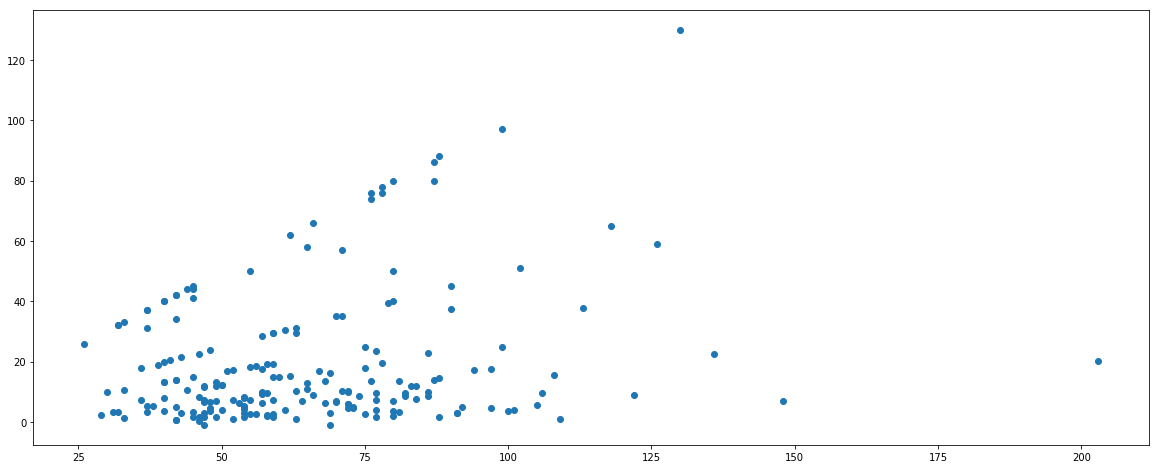

In [24]:
plt.scatter(df_partner.MaxSizeMeasure, df_partner.SizeMeasure_div_JunitRuns)